In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import statsmodels.api as sm
import seaborn as sns
import mne
import openpyxl as op

# Supplementary Table 1

In [ ]:
magnesium = pd.read_excel(r"D:\주성\documents\2025\Mg comma\clinical features2.xlsx", sheet_name='Table2')
magnesium1 = magnesium.loc[magnesium['Mg Protocol Type']==1]
magnesium2 = magnesium.loc[magnesium['Mg Protocol Type']==2]
print(magnesium1.describe())
print(magnesium2.describe())

from scipy.stats import mannwhitneyu as mann
for col in ['Mg Starting Date', 'Mg Infusion Day', 'Loading Mg', 'Maintenance Mg', 'Total Mg', 'Max concentration']:
    s, p = mann(magnesium1[col], magnesium2[col])
    print(col, s, p)

# Figure 4

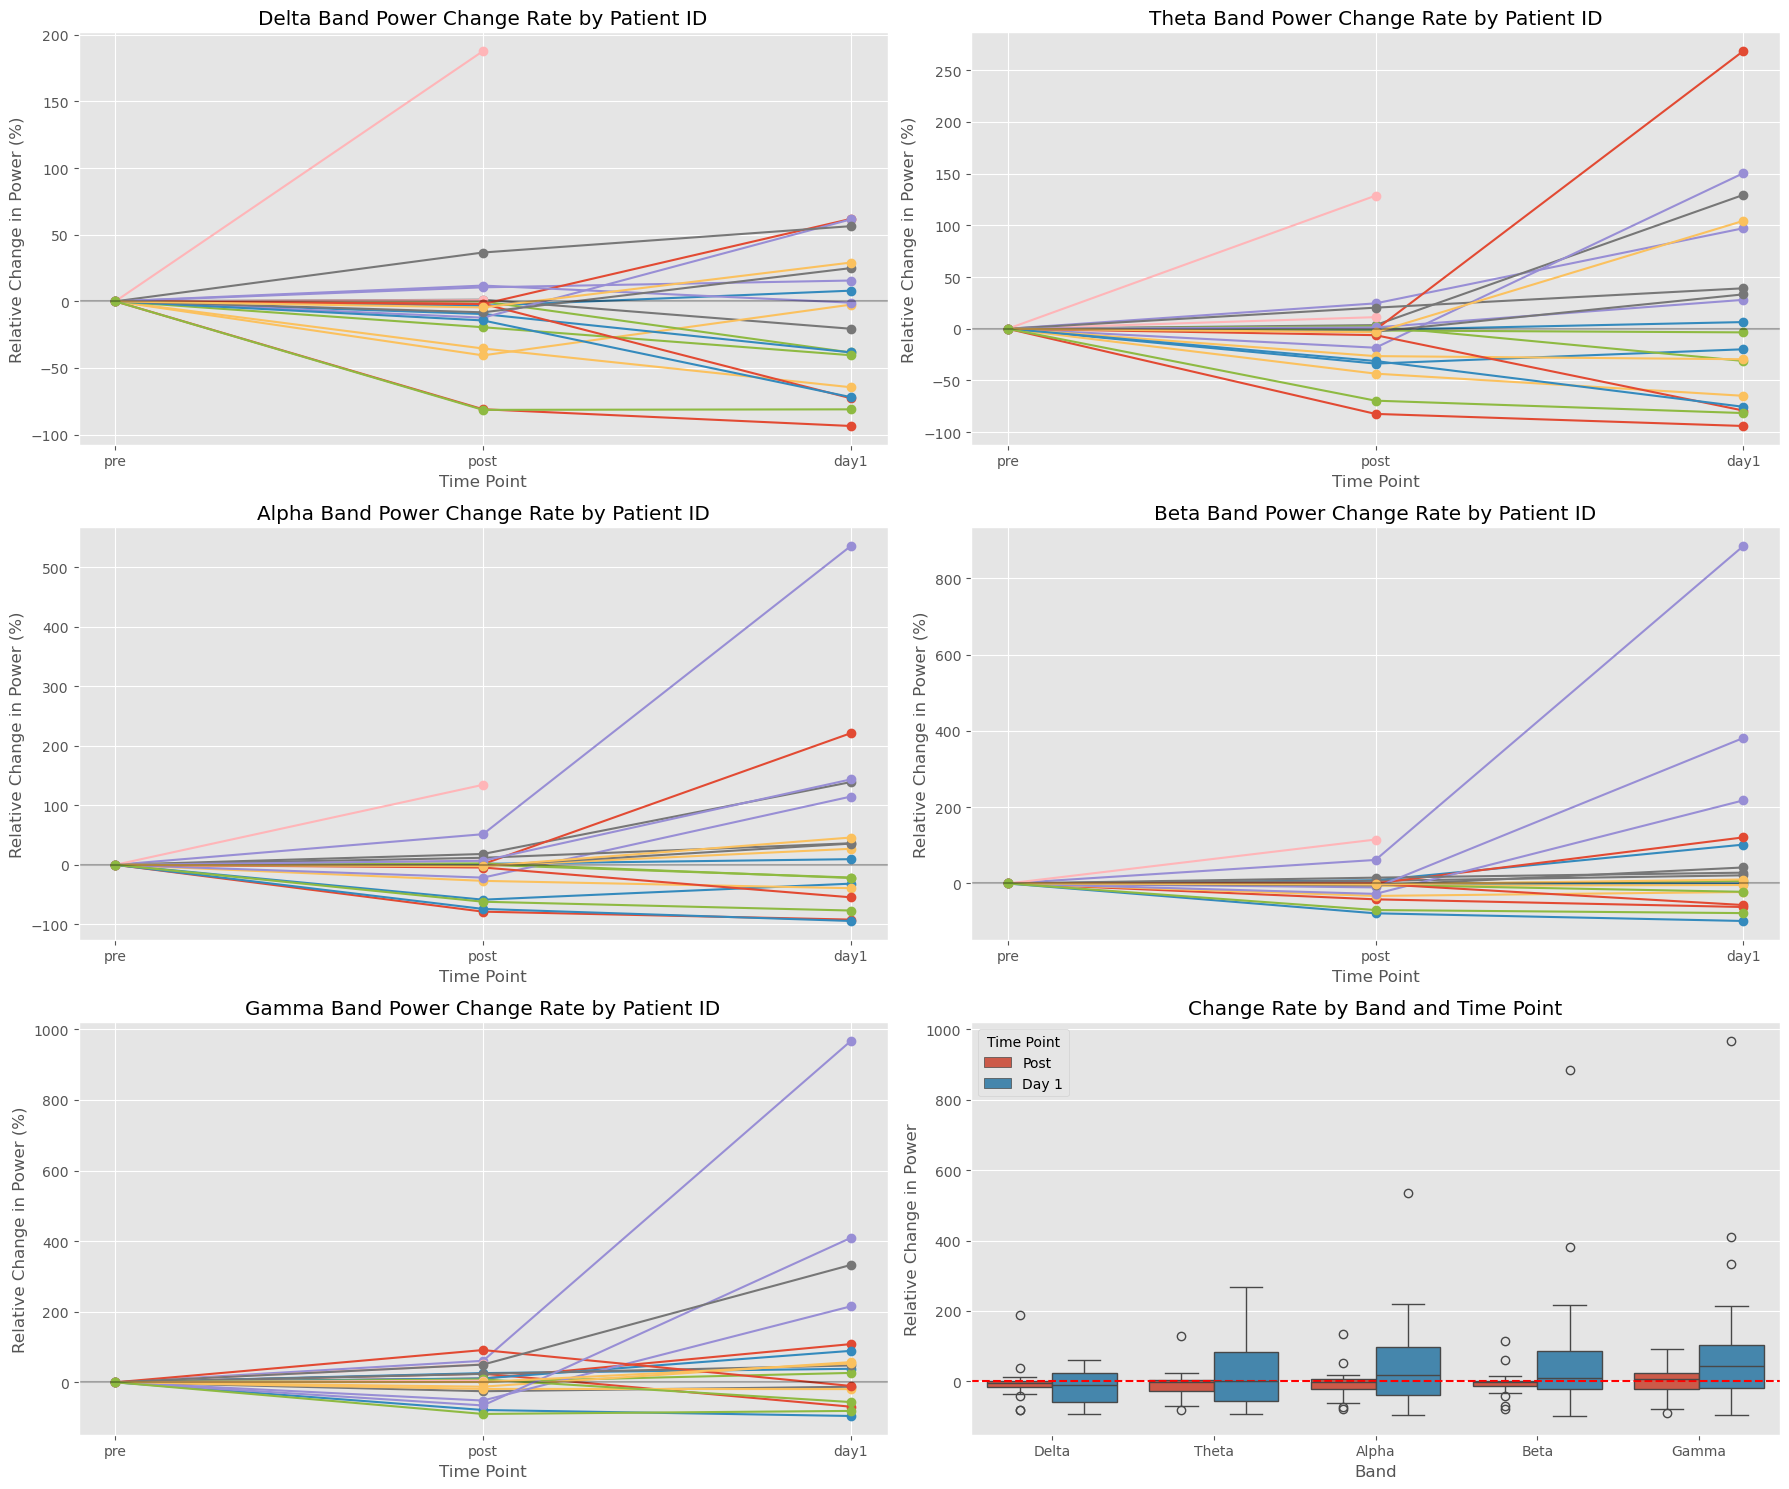

In [44]:
df = pd.read_excel(r"E:\주성\documents\2025\Mg comma\merged_power_data.xlsx", sheet_name = 'Sheet1')

# 변화율 계산
df['post_change'] = (df['post'] - df['pre']) / df['pre']*100
df['day1_change'] = (df['day1'] - df['pre']) / df['pre']*100

# 밴드별로 데이터 분리하기
bands = df['band'].unique()  # 모든 고유한 밴드 값 추출

# 그래프 스타일 설정
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 10

# 밴드 이름 첫 글자 대문자로 변경하는 함수
def capitalize_band(band_name):
    return band_name.capitalize()

# 큰 도표 생성 (3x2 그리드)
fig, axes = plt.subplots(3, 2, figsize=(18, 15))
axes = axes.flatten()  # 2D 배열을 1D로 변환하여 접근 용이하게 함

# 각 밴드별 그래프 생성 (첫 5개 서브플롯)
for i, band in enumerate(bands[:5]):  # 5개 밴드까지만 처리
    # 해당 밴드의 데이터만 필터링
    band_data = df[df['band'] == band].copy()
    
    # 각 환자 ID별 데이터 시각화
    for patient_id in band_data['ID'].unique():
        patient_data = band_data[band_data['ID'] == patient_id]
        
        # 시간 포인트를 x축으로 사용하기 위한 데이터 준비
        time_points = ['pre', 'post', 'day1']
        changes = [
            0,  # pre는 기준점이므로 변화율은 0
            patient_data['post_change'].values[0] if not patient_data['post_change'].isna().all() else np.nan,
            patient_data['day1_change'].values[0] if not patient_data['day1_change'].isna().all() else np.nan
        ]
        
        # 결측치가 있는 부분은 점선으로 표시
        valid_indices = ~np.isnan(changes)
        
        # 선 그래프로 표시 (결측치가 없는 부분)
        axes[i].plot(
            np.array(time_points)[valid_indices], 
            np.array(changes)[valid_indices], 
            marker='o', 
            label=f'ID: {patient_id}'
        )
        
        # 결측치가 있는 경우 점선으로 연결
        if not all(valid_indices):
            for j in range(len(time_points)-1):
                if valid_indices[j] and valid_indices[j+1]:
                    continue  # 두 지점 모두 유효하면 실선으로 이미 그려짐
                if valid_indices[j] or valid_indices[j+1]:  # 적어도 하나는 유효
                    axes[i].plot(
                        [time_points[j], time_points[j+1]], 
                        [changes[j], changes[j+1]], 
                        linestyle='--', 
                        alpha=0.5, 
                        color='gray'
                    )
    
    # 그래프 꾸미기
    axes[i].axhline(y=0, color='black', linestyle='-', alpha=0.3)  # 0 기준선 추가
    axes[i].set_title(f'{capitalize_band(band)} Band Power Change Rate by Patient ID')
    axes[i].set_xlabel('Time Point')
    axes[i].set_ylabel('Relative Change in Power (%)')
    axes[i].set_xticks(range(len(time_points)))
    axes[i].set_xticklabels(time_points)
    
    # 환자 ID가 많은 경우 범례를 그래프 밖에 표시하지 않고 제외
    if len(band_data['ID'].unique()) <= 10:
        axes[i].legend(fontsize='small')

# 마지막 서브플롯(6번째)에 박스플롯 두 개 그리기
# Post 변화율에 대한 박스플롯
box_data = pd.melt(df, id_vars=['band'], value_vars=['post_change', 'day1_change'], 
                   var_name='time_point', value_name='change_rate')
box_data['time_point'] = box_data['time_point'].map({'post_change': 'Post', 'day1_change': 'Day 1'})

# 밴드 이름 첫 글자 대문자로 변경
box_data['band'] = box_data['band'].apply(capitalize_band)

sns.boxplot(x='band', y='change_rate', hue='time_point', data=box_data, ax=axes[5])
axes[5].set_title('Change Rate by Band and Time Point')
axes[5].set_xlabel('Band')
axes[5].set_ylabel('Relative Change in Power')
axes[5].axhline(y=0, color='red', linestyle='--')
axes[5].legend(title='Time Point')

# 전체 레이아웃 조정
plt.tight_layout()
plt.savefig('all_bands_change_rate.png', dpi=300)
plt.show()

# 이전 버전의 post의 relative power에 대한 오름차순 막대그래프

In [ ]:
df = pd.read_csv(r"E:\주성\documents\2025\Mg comma\data2.csv")

# CSV 파일 읽기
data = df

# 밴드별로 데이터 나누기
bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']

plt.figure(figsize=(15, 10))
for idx, band in enumerate(bands, 1):
    plt.subplot(2, 3, idx)
    
    # 해당 밴드의 데이터만 추출
    band_data = data[data['band'] == band].copy()
    
    # 변화율 계산 ((post - pre) / pre)
    change = (band_data['mean_post_infusion'] - band_data['mean_pre_infusion']) / band_data['mean_pre_infusion']
    
    # 오름차순 정렬
    sorted_change = np.sort(change)
    
    # 바 차트 그리기
    plt.bar(range(len(sorted_change)), sorted_change)
    plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    plt.title(f'{band.capitalize()} Band')
    plt.ylim(-1, 2)  # y축 범위 수정

plt.suptitle('Power Change by Frequency Band', fontsize=14, y=1.02)    
plt.tight_layout()
plt.show()

# Table 3

비율 만드는 코드

In [ ]:
# clinical feature
feature = pd.read_excel(r"E:\주성\documents\2025\Mg comma\clinical features5.xlsx", sheet_name = 'Sheet1')
feature = feature.iloc[:-2, :]

# 파생변수 
feature['Immunotherapy'] = ~feature['Immunotherapy Medications'].isna()
feature['CIVADs'] = ~feature['CIVAD Medications'].isna()
feature['STESS_5'] = feature['STESS'] >= 5
feature['mRS_4'] = feature['mRS_premorbid'] >= 4
feature['CIVADs_num'] = feature['CIVAD Medications'].apply(lambda x: sum(1 for c in str(x) if c.isupper()) if pd.notna(x) else 0)
feature['Age_65'] = feature['Age'] >=65
feature['Mg_change'] = feature['max_Mg_conc'] - feature['Mg_baseline']
feature['Mg_8.5'] = feature['max_Mg_conc'] >= 8.5
feature['mRS_Discharge_4'] = feature['mRS_Discharge'] >= 4

# Total subject
total_subject = feature['response'].sum()
print("total response subject:", total_subject)

# 범주형
feature_cat = feature[['Class_SRSE', 'CIVADs', 'Sex', 'Immunotherapy',
    'Class_NORSE', 'Mg type', 'STESS_5', 'mRS_4', 'Age_65', 'Etiology', 
    'Sz Type', 'Mg_8.5', 'mRS_Discharge_4', 'Inhospital_Mortality'
]]

for col in feature_cat.columns:
    cross = pd.crosstab(feature_cat[col], feature['response'])
    print(cross)

# 연속형
feature_num = feature[['CIVADs_num', 'AED_number', 'Age', 'STESS',  'mRS_premorbid', 'max_Mg_conc', 'Mg_change', 'response', 'mRS_Discharge', 'Hospital_days', 'SE_Duration']]
print("responder", "\n", feature_num.loc[feature_num['response']==1].describe())
print("non-responder", "\n", feature_num.loc[feature_num['response']==0].describe())


total response subject: 13.0
response    0.0  1.0
Class_SRSE          
0.0           4    3
1.0           3   10
response  0.0  1.0
CIVADs            
False       4    3
True        3   10
response  0.0  1.0
Sex               
F           5    5
M           2    8
response       0.0  1.0
Immunotherapy          
False            3    5
True             4    8
response     0.0  1.0
Class_NORSE          
0.0            3    6
1.0            4    7
response  0.0  1.0
Mg type           
1.0         4   10
2.0         3    3
response  0.0  1.0
STESS_5           
False       2   10
True        5    3
response  0.0  1.0
mRS_4             
False       4   12
True        3    1
response  0.0  1.0
Age_65            
False       2    9
True        5    4
response                 0.0  1.0
Etiology                         
Acute vascular disease     1    0
Autoimmune                 2    4
Cryptogenic                3    3
Infectious encephalitis    0    1
Metabolic                  0    3
Remote va

통계값 구하기

In [24]:
# clinical feature
feature = pd.read_excel(r"D:\주성\documents\2025\Mg comma\clinical features4.xlsx", sheet_name = 'Sheet1')
feature = feature.iloc[:-2, :]

# 파생변수 
feature['Immunotherapy'] = ~feature['Immunotherapy Medications'].isna()
feature['CIVADs'] = ~feature['CIVAD Medications'].isna()
feature['STESS_5'] = feature['STESS'] >= 5
feature['mRS_4'] = feature['mRS_premorbid'] >= 4
feature['CIVADs_num'] = feature['CIVAD Medications'].apply(lambda x: sum(1 for c in str(x) if c.isupper()) if pd.notna(x) else 0)
feature['Age_65'] = feature['Age'] >=65
feature['Mg_change'] = feature['max_Mg_conc'] - feature['Mg_baseline']
feature['Mg_8.5'] = feature['max_Mg_conc'] >= 8.5
feature['mRS_Discharge_4'] = feature['mRS_Discharge'] >= 4

# fisher exact test

def fisher(table, alpha=0.05):
    # Fisher’s Exact Test 수행
    odds_ratio, p_value = stats.fisher_exact(table)
    return p_value 

# chi square test
def chisquare (table, alpha=0.05):
    chi, p_value, dof, exp = stats.chi2_contingency(table)
    return p_value

feature_cat = feature[['Class_SRSE', 'CIVADs', 'Sex', 'Immunotherapy',
    'Class_NORSE', 'Mg type', 'STESS_5', 'mRS_4', 'Age_65', 'Mg_8.5', 'mRS_Discharge_4', 'Inhospital_Mortality']]

feature_mulvar = feature[['Etiology', 'Sz Type']]

feature_num = feature[['CIVADs_num', 'AED_number', 
'Age', 'STESS',  'mRS_premorbid', 'max_Mg_conc', 'Mg_change', 'response', 'mRS_Discharge', 'Hospital_days', 'SE_Duration']]

results = {}
for col in feature_cat.columns:
    table = pd.crosstab(feature_cat[col], feature['response'])
    p_value = fisher(table)
    results[col] = {'p-value': p_value}

for col in feature_mulvar.columns:
    table = pd.crosstab(feature_mulvar[col], feature['response'])
    p_value = chisquare(table)
    results[col] = {'p-value': p_value}

for col in feature_num.columns:
    x = feature_num.loc[feature_num['response']==True][col]
    y = feature_num.loc[feature_num['response']==False][col]
    statistics, p_value = stats.mannwhitneyu(x, y)
    results[col] = {'p-value': p_value}

result_df = pd.DataFrame(results).T

In [25]:
result_df

,p-value
Class_SRSE,0.173581
CIVADs,0.173581
Sex,0.349845
Immunotherapy,1.000000
Class_NORSE,1.000000
Mg type,0.612616
STESS_5,0.062332
mRS_4,0.101135
Age_65,0.159675
Mg_8.5,1.000000


yes-no 처리방법에 따른 차이

In [ ]:
# clinical feature
feature = pd.read_excel(r"D:\주성\documents\2025\Mg comma\clinical features6.xlsx", sheet_name = 'Sheet1')
feature = feature.iloc[:-2, :]

# 파생변수 
feature['Immunotherapy'] = ~feature['Immunotherapy Medications'].isna()
feature['CIVADs'] = ~feature['CIVAD Medications'].isna()
feature['STESS_5'] = feature['STESS'] >= 5
feature['mRS_4'] = feature['mRS_premorbid'] >= 4
feature['CIVADs_num'] = feature['CIVAD Medications'].apply(lambda x: sum(1 for c in str(x) if c.isupper()) if pd.notna(x) else 0)
feature['Age_65'] = feature['Age'] >=65
feature['Mg_change'] = feature['max_Mg_conc'] - feature['Mg_baseline']
feature['Mg_8.5'] = feature['max_Mg_conc'] >= 8.5
feature['mRS_Discharge_4'] = feature['mRS_Discharge'] >= 4

# fisher exact test

def fisher(table, alpha=0.05):
    # Fisher’s Exact Test 수행
    odds_ratio, p_value = stats.fisher_exact(table)
    return p_value 

# chi square test
def chisquare (table, alpha=0.05):
    chi, p_value, dof, exp = stats.chi2_contingency(table)
    return p_value

feature_cat = feature[['Class_SRSE', 'CIVADs', 'Sex', 'Immunotherapy',
    'Class_NORSE', 'Mg type', 'STESS_5', 'mRS_4', 'Age_65', 'Mg_8.5', 'mRS_Discharge_4', 'Inhospital_Mortality']]

feature_mulvar = feature[['Etiology', 'Sz Type']]

feature_num = feature[['CIVADs_num', 'AED_number', 
'Age', 'STESS',  'mRS_premorbid', 'max_Mg_conc', 'Mg_change', 'mRS_Discharge', 'Hospital_days', 'SE_Duration']]

results = {}
for col in feature_cat.columns:
    table = pd.crosstab(feature_cat[col], feature['response_yesnoyes'])
    p_value = fisher(table)
    results[col] = {'p-value': p_value}

for col in feature_mulvar.columns:
    table = pd.crosstab(feature_mulvar[col], feature['response_yesnoyes'])
    p_value = chisquare(table)
    results[col] = {'p-value': p_value}

for col in feature_num.columns:
    if feature_num[col].isna().sum() != 0:
        feature_num2 = feature_num.copy().dropna() 
        x = feature_num2.loc[feature['response_yesnoyes']=="y"][col]
        y = feature_num2.loc[feature['response_yesnoyes']=="n"][col]
        statistics, p_value = stats.mannwhitneyu(x, y)
        results[col] = {'p-value': p_value}
    else: 
        x = feature_num.loc[feature['response_yesnoyes']=="y"][col]
        y = feature_num.loc[feature['response_yesnoyes']=="n"][col]
        statistics, p_value = stats.mannwhitneyu(x, y)
        results[col] = {'p-value': p_value}        

result_df1 = pd.DataFrame(results).T

results = {}
for col in feature_cat.columns:
    table = pd.crosstab(feature_cat[col], feature['response_yesnoout'])
    p_value = fisher(table)
    results[col] = {'p-value': p_value}

for col in feature_mulvar.columns:
    table = pd.crosstab(feature_mulvar[col], feature['response_yesnoout'])
    p_value = chisquare(table)
    results[col] = {'p-value': p_value}

for col in feature_num.columns:
    if feature_num[col].isna().sum() != 0:
        feature_num2 = feature_num.copy().dropna() 
        x = feature_num2.loc[feature['response_yesnoout']=="y"][col]
        y = feature_num2.loc[feature['response_yesnoout']=="n"][col]
        statistics, p_value = stats.mannwhitneyu(x, y)
        results[col] = {'p-value': p_value}
    else: 
        x = feature_num.loc[feature['response_yesnoout']=="y"][col]
        y = feature_num.loc[feature['response_yesnoout']=="n"][col]
        statistics, p_value = stats.mannwhitneyu(x, y)
        results[col] = {'p-value': p_value}        

result_df2 = pd.DataFrame(results).T

result_df = result_df1.join(result_df2, how='inner', lsuffix='_yes_no_to_yes', rsuffix='_yes_no_exclude')

In [41]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import chi2_contingency, fisher_exact

# clinical feature
feature = pd.read_excel(r"D:\주성\documents\2025\Mg comma\clinical features6.xlsx", sheet_name = 'Sheet1')
feature = feature.iloc[:-2, :]

# 파생변수 
feature['Immunotherapy'] = ~feature['Immunotherapy Medications'].isna()
feature['CIVADs'] = ~feature['CIVAD Medications'].isna()
feature['STESS_5'] = feature['STESS'] >= 5
feature['mRS_4'] = feature['mRS_premorbid'] >= 4
feature['CIVADs_num'] = feature['CIVAD Medications'].apply(lambda x: sum(1 for c in str(x) if c.isupper()) if pd.notna(x) else 0)
feature['Age_65'] = feature['Age'] >=65
feature['Mg_change'] = feature['max_Mg_conc'] - feature['Mg_baseline']
feature['Mg_8.5'] = feature['max_Mg_conc'] >= 8.5
feature['mRS_Discharge_4'] = feature['mRS_Discharge'] >= 4

# 변수 형태에 따라 나누기
feature_cat = feature[['Class_SRSE', 'CIVADs', 'Sex', 'Immunotherapy',
    'Class_NORSE', 'Mg type', 'STESS_5', 'mRS_4', 'Age_65', 'Mg_8.5', 'mRS_Discharge_4', 'Inhospital_Mortality']]

feature_mulvar = feature[['Etiology', 'Sz Type']]

feature_num = feature[['CIVADs_num', 'AED_number', 
'Age', 'STESS',  'mRS_premorbid', 'max_Mg_conc', 'Mg_change', 'mRS_Discharge', 'Hospital_days', 'SE_Duration']]


cross = pd.crosstab(feature_cat['STESS_5'], feature['response'])
cross
table2x2 = sm.stats.Table2x2(cross)

odds_ratio = table2x2.oddsratio
odds_ratio_ci = table2x2.oddsratio_confint()

cross

response,0.0,1.0
STESS_5,,
False,2,10
True,5,3


In [42]:
import numpy as np
import pandas as pd

# 예시 2x2 분할표: [[a, b], [c, d]]
observed_table = np.array([[2, 10],
                           [5, 3]])

def compute_odds_ratio(table):
    # a, b, c, d
    a, b = table[0]
    c, d = table[1]
    # b나 c가 0이면 계산 시 문제가 발생할 수 있으니, 작은 값(예: 0.5)을 더해 조정할 수 있음
    return (a * d) / (b * c) if (b * c) != 0 else np.nan

# 부트스트랩 함수
def bootstrap_odds_ratio(observed_table, n_bootstrap=10000):
    # 원 데이터에 기반해 '개별 관측치'를 재구성합니다.
    # 여기서는 각 셀의 값이 빈도를 나타내므로, 각 셀의 값을 해당 빈도만큼의 '사건'으로 재구성
    a, b = observed_table[0]
    c, d = observed_table[1]
    
    # 두 변수에 대한 각 관측치를 리스트 형태로 생성
    group1 = [1] * a + [0] * b
    group2 = [1] * c + [0] * d
    
    n1 = len(group1)
    n2 = len(group2)
    
    boot_odds = []
    for _ in range(n_bootstrap):
        sample1 = np.random.choice(group1, size=n1, replace=True)
        sample2 = np.random.choice(group2, size=n2, replace=True)
        # 재구성된 분할표
        a_bs = np.sum(sample1)
        b_bs = n1 - a_bs
        c_bs = np.sum(sample2)
        d_bs = n2 - c_bs
        # 만약 0으로 나누는 상황을 피하기 위해서 조정
        if b_bs == 0 or c_bs == 0:
            continue
        table_bs = np.array([[a_bs, b_bs],
                             [c_bs, d_bs]])
        boot_odds.append(compute_odds_ratio(table_bs))
    
    boot_odds = np.array(boot_odds)
    lower = np.percentile(boot_odds, 2.5)
    upper = np.percentile(boot_odds, 97.5)
    return np.median(boot_odds), (lower, upper)

# 부트스트랩 실행
median_or, ci = bootstrap_odds_ratio(observed_table, n_bootstrap=10000)
print(f"부트스트랩 기반 오즈비 중앙값: {median_or:.4f}")
print(f"부트스트랩 기반 95% 신뢰구간: {ci}")

부트스트랩 기반 오즈비 중앙값: 0.1020
부트스트랩 기반 95% 신뢰구간: (np.float64(0.0), np.float64(0.8333333333333334))


In [ ]:
for col in feature_cat.columns:
    print(col)
    print(feature_cat[col].unique())
    print(feature_cat[col].dtype)
    print(pd.crosstab(feature_cat[col], feature['response']))


[1. 0.]
float64
response    0.0  1.0
Class_SRSE          
0.0           4    3
1.0           3   10
[ True False]
bool
response  0.0  1.0
CIVADs            
False       4    3
True        3   10
['F' 'M']
object
response  0.0  1.0
Sex               
F           5    5
M           2    8
[ True False]
bool
response       0.0  1.0
Immunotherapy          
False            3    5
True             4    8
[0. 1.]
float64
response     0.0  1.0
Class_NORSE          
0.0            3    6
1.0            4    7
[2. 1.]
float64
response  0.0  1.0
Mg type           
1.0         4   10
2.0         3    3
[False  True]
bool
response  0.0  1.0
STESS_5           
False       2   10
True        5    3
[False  True]
bool
response  0.0  1.0
mRS_4             
False       4   12
True        3    1
[False  True]
bool
response  0.0  1.0
Age_65            
False       2    9
True        5    4
[ True False]
bool
response  0.0  1.0
Mg_8.5            
False       6   10
True        1    3
[ True False]
bool
re

# 타임 포인트에 대한 RM ANOVA (개인 수준의 분석) at Results

정규성 검정을 일단 하고, ANOVA 및 partial eta-squared와 omega squared를 구해보자

In [ ]:
name_list = [
    고정실,김가람,김득실,김영현,김충연,민병춘1,박주연1,
    벌,안중훈,윤병시,이미우,임석봉,전창희,
    정금례,정용태,이귀임,정복연,김정한,정광훈1,조진욱]



In [ ]:
# 부분 에타 제곱 계산 함수
def partial_eta_squared(f_value, df_effect, df_error):
    """
    계산된 F 값과 자유도로부터 부분 에타 제곱 계산
    
    Parameters:
    -----------
    f_value : float
        F-통계량 값
    df_effect : int
        효과(처리)의 자유도
    df_error : int
        오차의 자유도
        
    Returns:
    --------
    float
        부분 에타 제곱 값 (0~1 사이)
    """
    return (f_value * df_effect) / (f_value * df_effect + df_error)

# Define Cohens'D
def cohens_d(group1, group2):
    mean1, mean2 = np.mean(group1), np.mean(group2)
    std1, std2 = np.std(group1, ddof=1), np.std(group2, ddof=1)
    n1, n2 = len(group1), len(group2)
    pooled_std = np.sqrt(((n1 - 1) * std1**2 + (n2 - 1) * std2**2) / (n1 + n2 - 2))
    return (mean1 - mean2) / pooled_std



In [23]:
# Removing large artifact by band 함수 정의
def remove_artifacts(before_mean, after_mean, large_artifact):
    before_idx = set()
    after_idx = set()

    for t_start, t_end in large_artifact:
        if t_start < 3600 and t_end < 3600:
            before_idx.update(range(t_start*200, t_end*200))
            after_idx.update(range(t_start*200, t_end*200))
        elif t_start < 3600 and t_end >= 3600:
            before_idx.update(range(t_start*200, 3600*200))
            after_idx.update(range(t_start*200, 3600*200))
            after_idx.update(range(0, (t_end-3600)*200))
            before_idx.update(range(0, (t_end-3600)*200))
        else:
            after_idx.update(range((t_start-3600)*200, (t_end-3600)*200))
            before_idx.update(range((t_start-3600)*200, (t_end-3600)*200))

    before_idx = sorted(before_idx)
    after_idx = sorted(after_idx)

    return np.delete(before_mean, before_idx), np.delete(after_mean, after_idx)

# Process band data 함수 정의
def process_band_data(tfr_data, tfr_data_day1, large_artifact):
    start1, end1 = 0, 3599 * 200
    start2, end2 = 3600 * 200, 7199 * 200

    # Split before and after
    before = tfr_data[:, :, start1:end1]
    after = tfr_data[:, :, start2:end2]
    day1 = tfr_data_day1

    # Average over channels and frequencies
    before_mean_channel = before.mean(axis=0)
    after_mean_channel = after.mean(axis=0)
    day1_mean_channel = day1.mean(axis=0)
    
    before_mean = before_mean_channel.mean(axis=0)
    after_mean = after_mean_channel.mean(axis=0)
    day1_mean = day1_mean_channel.mean(axis=0)

    before_clean, after_clean = remove_artifacts(before_mean, after_mean, large_artifact)
    day1_clean = day1_mean.copy()
    # Remove artifacts
    return before_clean, after_clean, day1_clean

# Main 함수 정의
def main():
    # Initialize name dictionary
    names = ['고정실', '김가람', '김득실', '김영현', '김충연', '민병춘1', '박주연1', '박주연2', '벌', 
             '안중훈', '윤병시', '이미우', '임석봉', '전창희', '정광훈2', '정금례', '정용태', '이귀임', 
             '정복연', '김정한', '정광훈1', '조진욱']
    name_dict = {name: i+1 for i, name in enumerate(names)}

    # Get analysis targets
    name_list = input("분석대상 이름을 입력하세요. (여러명일 경우 쉼표로 구분)").split(',')
    print(f'분석대상은 {name_list}입니다.')

    ## Load workbook and artifact data
    #wb = op.load_workbook(r"C:\Users\esin4\OneDrive\바탕 화면\Github\Mg_infusion_coma\Mg_infusion_data.xlsx")
    large_artifact_data = pd.read_csv(r"C:\Users\Brain_Science\Documents\GitHub\Mg_infusion_coma\large_artifact.csv", encoding='utf-8-sig')

    # Process each name
    for name in name_list:
        print(f'{name}의 데이터를 분석합니다.')
        
        # Get large artifacts
        large_artifact = []
        if name in large_artifact_data['Name'].values:
            coordinates = large_artifact_data[large_artifact_data['Name'] == name]['Coordinates'].values[0]
            if coordinates != 'skip':
                large_artifact = eval(coordinates)
        print(f"{name}의 large artifact: {large_artifact}")

        ## Get row number
        #row = name_dict.get(name)
        #if row is None:
        #    print(f"{name}이(가) name_dict에 없습니다.")
        #    exit()

        # Store band data in dictionary
        tfr_data = {}
        tfr_data_day1 = {}
        
        # Load band data
        for band in ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma1', 'Gamma2']:
            file_path = rf'E:\Mg_EEG\tfr_files_gamma\{name}{band}_7200_tfr.h5'
            file_path_day1 = rf"E:\Mg_EEG\tfr_files_subacute\{name}_day1_{band}_tfr.h5"
            tfr = mne.time_frequency.read_tfrs(file_path)
            tfr_day1 = mne.time_frequency.read_tfrs(file_path_day1)
            tfr_data[band] = tfr.data
            tfr_data_day1[band] = tfr_day1.data
            del tfr, tfr_day1
        print(f"{name}의 데이터를 불러왔습니다.")

        # Combine Gamma bands
        if 'Gamma1' in tfr_data and 'Gamma2' in tfr_data:
            tfr_data['Gamma'] = np.concatenate([tfr_data['Gamma1'], tfr_data['Gamma2']], axis=1)
            del tfr_data['Gamma1'], tfr_data['Gamma2']
        if 'Gamma1' in tfr_data_day1 and 'Gamma2' in tfr_data_day1:
            tfr_data_day1['Gamma'] = np.concatenate([tfr_data_day1['Gamma1'], tfr_data_day1['Gamma2']], axis=1)
        print(f"{name}의 Gamma1과 Gamma2 데이터를 결합했습니다.")

        # Process each band
        for band in ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']:
            if band not in tfr_data:
                print(f"Warning: {band} data not found")
                exit()
                
            before_clean, after_clean, day1_clean = process_band_data(tfr_data[band], tfr_data_day1[band], large_artifact)
            print(f"{band} 데이터의 artifact를 제거했습니다.")
            
            #run_tests(before_clean, after_clean, band, wb, row, name)
            #print(f"{band} 데이터의 테스트를 실행했습니다.")
            
            del tfr_data[band]
            print(f"{band} 데이터를 삭제했습니다.")
        return before_clean, after_clean, day1_clean
    ## Save results
    #wb.save(r"C:\Users\esin4\OneDrive\바탕 화면\Github\Mg_infusion_coma\Mg_infusion_data.xlsx")
    #print(f"{name_list}의 데이터 분석결과를 저장했습니다.")
    #print(f"{name_list}의 데이터 분석이 완료되었습니다.")

In [24]:
before_clean, after_clean, day1_clean = main()

분석대상은 ['고정실']입니다.
고정실의 데이터를 분석합니다.
고정실의 large artifact: []
Reading E:\Mg_EEG\tfr_files_gamma\고정실Delta_7200_tfr.h5 ...
Reading E:\Mg_EEG\tfr_files_subacute\고정실_day1_Delta_tfr.h5 ...
Reading E:\Mg_EEG\tfr_files_gamma\고정실Theta_7200_tfr.h5 ...
Reading E:\Mg_EEG\tfr_files_subacute\고정실_day1_Theta_tfr.h5 ...
Reading E:\Mg_EEG\tfr_files_gamma\고정실Alpha_7200_tfr.h5 ...
Reading E:\Mg_EEG\tfr_files_subacute\고정실_day1_Alpha_tfr.h5 ...
Reading E:\Mg_EEG\tfr_files_gamma\고정실Beta_7200_tfr.h5 ...
Reading E:\Mg_EEG\tfr_files_subacute\고정실_day1_Beta_tfr.h5 ...
Reading E:\Mg_EEG\tfr_files_gamma\고정실Gamma1_7200_tfr.h5 ...
Reading E:\Mg_EEG\tfr_files_subacute\고정실_day1_Gamma1_tfr.h5 ...
Reading E:\Mg_EEG\tfr_files_gamma\고정실Gamma2_7200_tfr.h5 ...
Reading E:\Mg_EEG\tfr_files_subacute\고정실_day1_Gamma2_tfr.h5 ...
고정실의 데이터를 불러왔습니다.
고정실의 Gamma1과 Gamma2 데이터를 결합했습니다.
Delta 데이터의 artifact를 제거했습니다.
Delta 데이터를 삭제했습니다.
Theta 데이터의 artifact를 제거했습니다.
Theta 데이터를 삭제했습니다.
Alpha 데이터의 artifact를 제거했습니다.
Alpha 데이터를 삭제했습니다.
Beta 데이터의 ar

In [31]:
day1_clean.shape

(60200,)

In [37]:
for group in [before_clean, after_clean, day1_clean]:
    stat, p = stats.shapiro(group)
    print(f"Shapiro-Wilk Test p-value: {p:.4f}")

Shapiro-Wilk Test p-value: 0.0000
Shapiro-Wilk Test p-value: 0.0000
Shapiro-Wilk Test p-value: 0.0000


c:\Users\Brain_Science\anaconda3\envs\mne\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 719800.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\Brain_Science\anaconda3\envs\mne\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 714801.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\Brain_Science\anaconda3\envs\mne\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 60200.
  res = hypotest_fun_out(*samples, **kwds)


In [38]:
stat, p = stats.levene(before_clean, after_clean, day1_clean)
print(f"Levene Test p-value: {p:.4f}")


Levene Test p-value: 0.0000


In [39]:
from scipy import stats

# ANOVA 수행
f_stat, p_value = stats.f_oneway(before_clean, after_clean, day1_clean)

print(f"F-statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# 결과 해석
alpha = 0.05  # 유의수준 설정
if p_value < alpha:
    print("유의한 차이가 있음 (귀무가설 기각)")
else:
    print("그룹 간 평균 차이가 없음 (귀무가설 채택)")


F-statistic: 13967.8453
P-value: 0.0000
유의한 차이가 있음 (귀무가설 기각)


In [40]:
import pandas as pd
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# 데이터 준비 (NumPy 배열을 Pandas DataFrame 형태로 변환)
data = pd.DataFrame({
    'score': np.concatenate([before_clean, after_clean, day1_clean]),
    'group': (['before_clean'] * len(before_clean)) +
             (['after_clean'] * len(after_clean)) +
             (['day1_clean'] * len(day1_clean))
})

# Tukey's HSD 사후검정 수행
tukey_result = pairwise_tukeyhsd(data['score'], data['group'], alpha=0.05)
print(tukey_result)

    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
   group1       group2    meandiff p-adj lower upper reject
-----------------------------------------------------------
 after_clean before_clean     -0.0   0.0  -0.0  -0.0   True
 after_clean   day1_clean     -0.0   0.0  -0.0  -0.0   True
before_clean   day1_clean     -0.0   0.0  -0.0  -0.0   True
-----------------------------------------------------------


# Table 2

In [ ]:
df = pd.read_excel(r"E:\주성\documents\2025\Mg comma\merged_power_data.xlsx")

# 변화율 계산
df['post_change'] = (df['post'] - df['pre']) / df['pre']*100
df['day1_change'] = (df['day1'] - df['pre']) / df['pre']*100

# relative change 중앙값 및 Q1, Q3
print('total')
print(df[['post_change', 'day1_change']].describe())
for band in df['band'].unique():
    print(band)
    print(df.loc[df['band']==band][['post_change', 'day1_change']].describe().round(2))

# 감소한 수 및 비율
print('total')
post = print((df['post_change'] < 0).sum())
print(post)
print(post/100)
day1 = print((df['day1_change'] < 0).sum())
print(day1)
print(day1/100)

for band in df['band'].unique():
    print(band)
     = print((df['post_change'] < 0).sum())

total
       post_change  day1_change
count   100.000000    90.000000
mean     -3.498004    49.542982
std      45.214776   176.112183
min     -89.675440   -98.306560
25%     -22.459492   -40.141075
50%      -1.759686     7.244740
75%       8.266117    60.424462
max     187.783066   966.646019
delta
       post_change  day1_change
count        20.00        18.00
mean         -3.25       -14.85
std          53.14        50.59
min         -81.44       -93.52
25%         -15.61       -58.44
50%          -3.94       -11.52
75%           0.96        22.60
max         187.78        61.84
theta
       post_change  day1_change
count        20.00        18.00
mean         -6.43        21.00
std          42.06        97.39
min         -82.34       -94.01
25%         -27.63       -56.40
50%          -2.19         1.50
75%           2.66        82.68
max         128.72       268.57
alpha
       post_change  day1_change
count        20.00        18.00
mean         -4.89        48.65
std          46.

# Supplementary Table 2

In [22]:
df = pd.read_excel(r"D:\주성\documents\2025\Mg comma\clinical features6.xlsx", sheet_name='Sheet1')
df = df.iloc[:-2, :]

df1 = df[['Mg type', 'mRS_Discharge', 'mRS_3mo_text', 'Inhospital_Mortality', 'SE_Duration', 'Hospital_days']]
df1['mRS_Discharge_4'] = df1['mRS_Discharge'] >=4
df1['mRS_Discharge_5'] = df1['mRS_Discharge'] >=5

for col in ['mRS_Discharge', 'SE_Duration', 'Hospital_days']:
    x = df1.loc[df1['Mg type']==1][col]
    y = df1.loc[df1['Mg type']==2][col]
    s, p = stats.mannwhitneyu(x, y)
    print(col, p, x.median(), x.quantile(0.25), x.quantile(0.75), y.median(), y.quantile(0.25), y.quantile(0.75))

for col in ['mRS_Discharge_4', 'Inhospital_Mortality', 'mRS_Discharge_5']:
    cross = pd.crosstab(df1['Mg type'], df1[col])
    s, p = stats.fisher_exact(cross)
    print(col, cross, p)

mRS_Discharge 0.09532284853830619 5.0 3.25 5.0 5.5 5.0 6.0
SE_Duration 0.0012751531467836055 10.5 5.75 17.25 83.0 55.75 87.0
Hospital_days 0.09062991577531594 31.0 15.0 64.5 83.0 55.75 87.0
mRS_Discharge_4 mRS_Discharge_4  False  True 
Mg type                      
1.0                  4     10
2.0                  0      6 0.2674922600619196
Inhospital_Mortality Inhospital_Mortality  0.0  1.0
Mg type                       
1.0                    11    3
2.0                     3    3 0.30270897832817334
mRS_Discharge_5 mRS_Discharge_5  False  True 
Mg type                      
1.0                  5      9
2.0                  0      6 0.26044891640866874


C:\Users\Brain_Science\AppData\Local\Temp\ipykernel_1964\2740586278.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['mRS_Discharge_4'] = df1['mRS_Discharge'] >=4
C:\Users\Brain_Science\AppData\Local\Temp\ipykernel_1964\2740586278.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['mRS_Discharge_5'] = df1['mRS_Discharge'] >=5


In [30]:
import pandas as pd
import numpy as np
from scipy import stats

# 결과를 저장할 빈 리스트 생성
results = []

# 1부터 20까지 각 임곗값에 대해 반복
for time in range(1, 21):
    # 각 임곗값별로 새로운 불린 변수 생성
    col_time = f'time_{time}'
    df2[col_time] = df2['time_until_Mg'] >= time
    
    # 각 임곗값에 대한 결과를 저장할 딕셔너리 생성
    res = {'threshold': time}
    
    # 연속형 변수 (Mann-Whitney U 검정)
    for col in ['mRS_Discharge', 'SE_Duration', 'Hospital_days']:
        group_true = df2.loc[df2[col_time] == True, col]
        group_false = df2.loc[df2[col_time] == False, col]
        
        # 두 그룹간의 차이를 검정
        try:
            s, p_val = stats.mannwhitneyu(group_true, group_false)
        except Exception as e:
            p_val = np.nan
        
        # 결과 저장 (p-value, 그룹별 중앙값 등)
        res[f'p_{col}'] = p_val
        res[f'{col}_median_true'] = group_true.median()
        res[f'{col}_median_false'] = group_false.median()
        # 추가로 사분위수 등 다른 통계치를 저장할 수도 있음
        res[f'{col}_Q1_true'] = group_true.quantile(0.25)
        res[f'{col}_Q3_true'] = group_true.quantile(0.75)
        res[f'{col}_Q1_false'] = group_false.quantile(0.25)
        res[f'{col}_Q3_false'] = group_false.quantile(0.75)
    
    # 범주형 변수 (Fisher의 정확 검정)
    for col in ['mRS_Discharge_4', 'Inhospital_Mortality', 'mRS_Discharge_5']:
        cross = pd.crosstab(df2[col_time], df2[col])
        try:
            # Fisher 검정은 2x2 교차표에 적합하므로, 그렇지 않을 경우 오류가 날 수 있음
            s, p_cat = stats.fisher_exact(cross)
        except Exception as e:
            p_cat = np.nan
        res[f'p_{col}'] = p_cat
        
    # 결과 리스트에 추가
    results.append(res)

# 결과를 DataFrame으로 변환하여 확인
result_df = pd.DataFrame(results)
print(result_df)


C:\Users\Brain_Science\AppData\Local\Temp\ipykernel_1964\1709588847.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[col_time] = df2['time_until_Mg'] >= time
C:\Users\Brain_Science\AppData\Local\Temp\ipykernel_1964\1709588847.py:24: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  s, p_val = stats.mannwhitneyu(group_true, group_false)
C:\Users\Brain_Science\AppData\Local\Temp\ipykernel_1964\1709588847.py:24: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  s, p_val = stats.mannwhitneyu(group_true, group_false)
C:\Users\Brain_Science\AppData\Local\T

    threshold  p_mRS_Discharge  mRS_Discharge_median_true  \
0           1              NaN                        5.0   
1           2         0.609364                        5.0   
2           3         0.157033                        5.0   
3           4         0.147546                        5.0   
4           5         0.147546                        5.0   
5           6         0.147546                        5.0   
6           7         0.311479                        5.0   
7           8         0.311479                        5.0   
8           9         0.095323                        5.5   
9          10         0.264907                        5.0   
10         11         0.615058                        5.0   
11         12         0.615058                        5.0   
12         13         0.615058                        5.0   
13         14         0.615058                        5.0   
14         15         0.615058                        5.0   
15         16         0.

C:\Users\Brain_Science\AppData\Local\Temp\ipykernel_1964\1709588847.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[col_time] = df2['time_until_Mg'] >= time
C:\Users\Brain_Science\AppData\Local\Temp\ipykernel_1964\1709588847.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[col_time] = df2['time_until_Mg'] >= time
C:\Users\Brain_Science\AppData\Local\Temp\ipykernel_1964\1709588847.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

In [33]:
result_df.to_csv(r"D:\주성\documents\2025\Mg comma\result_df.csv")

In [35]:
result_df.loc[result_df['threshold']==11].T

,10
threshold,11.000000
p_mRS_Discharge,0.615058
mRS_Discharge_median_true,5.000000
mRS_Discharge_median_false,5.000000
mRS_Discharge_Q1_true,5.000000
mRS_Discharge_Q3_true,5.250000
mRS_Discharge_Q1_false,3.750000
mRS_Discharge_Q3_false,6.000000
p_SE_Duration,0.002873
SE_Duration_median_true,86.000000
